In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline

In [119]:
train = pd.read_csv('./Clean/Titanic_Train_Clean.csv',index_col=0)
test = pd.read_csv('./Clean/Titanic_Test_Clean.csv',index_col=0)

### Linear Regression

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold

In [8]:
lr = LinearRegression() #Define the function

In [18]:
kf = KFold(len(train), n_folds=10, random_state=1) #Define k-fold cross validation

In [22]:
predictions = []
features = list(test.columns)

for tr, te in kf:
    trainers = (train[features].iloc[tr,:])
    targets = train['Survived'].iloc[tr]
    testers = train[features].iloc[te]
    
    lr.fit(trainers,targets)
    prediction = lr.predict(testers)
    predictions.append(prediction)

In [26]:
predictions = np.concatenate(predictions,axis=0)

ValueError: zero-dimensional arrays cannot be concatenated

In [36]:
predictions[predictions>0.5] = 1
predictions[predictions<=0.5] = 0

# len(train['Survived'])
accuracy=sum(train["Survived"]==predictions)*1.0/len(train["Survived"])
accuracy

0.81930415263748602

### Logistic Regression

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [38]:
Xlr, Xtestlr, ylr, ytestlr = train_test_split(train[features].values,train['Survived'].values,random_state = 1)

In [48]:
lr = LogisticRegression(C=100)

In [49]:
lr.fit(Xlr,ylr)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [50]:
print (accuracy_score(lr.predict(Xtestlr),ytestlr))

0.825112107623


**Grid Search to define C (hyperparameter)**

In [83]:
from sklearn.model_selection import GridSearchCV, cross_val_score, ShuffleSplit

lr = LogisticRegression()
parameters = {"C":[0.0001,0.001,0.01,0.1,1,10,100]}
cv = ShuffleSplit(n_splits=10,test_size=0.3,random_state=50)

model = GridSearchCV(lr,param_grid=parameters,cv=cv)
model.fit(Xlr,ylr)

model.best_params_, model.best_score_

({'C': 1}, 0.8233830845771144)

In [68]:
lr = LogisticRegression(C=100)
cv = ShuffleSplit(n_splits=10,test_size=0.3,random_state=50)

scores = cross_val_score(lr,train[features],train['Survived'],scoring='f1',cv=cv)
print (scores)
print (scores.mean())

[ 0.78431373  0.70967742  0.75126904  0.80808081  0.79227053  0.72164948
  0.74626866  0.77837838  0.78350515  0.75126904]
0.762668222966


### Random Forest

In [105]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=1, n_estimators=50, max_depth=8,min_samples_split=6, min_samples_leaf=4)

# rf.fit(train[features],train["Survived"])

kf = KFold(train.shape[0], n_folds=5, random_state=1)

# predictions = cross_validation.cross_val_predict(rf, titanic[predictors],titanic["Survived"],cv=kf)
# predictions = pd.Series(predictions)

scores = cross_val_score(rf, train[features], train["Survived"],scoring='f1', cv=kf)
# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.768065813439


** Important Features **

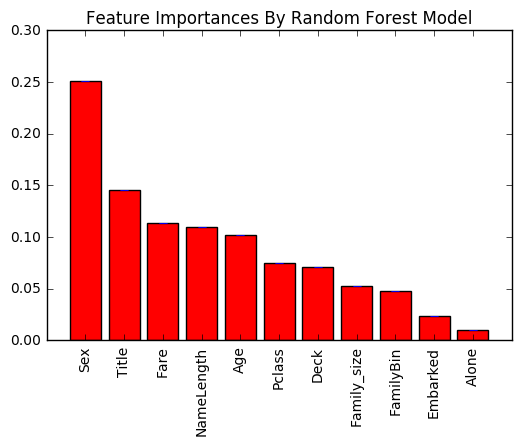

In [109]:
rf = RandomForestClassifier(random_state=1, n_estimators=50, max_depth=8,min_samples_split=6, min_samples_leaf=4)
rf.fit(train[features],train["Survived"])

importances=rf.feature_importances_

std = np.std([rf.feature_importances_ for tree in rf.estimators_],
             axis=0)

indices = np.argsort(importances)[::-1]
sorted_important_features=[]

for i in indices:
    sorted_important_features.append(features[i])
#predictors=titanic.columns
plt.figure()
plt.title("Feature Importances By Random Forest Model")
plt.bar(range(np.size(features)), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(np.size(features)), sorted_important_features, rotation='vertical')

plt.xlim([-1, np.size(features)]);

### AdaBoost

In [117]:
from sklearn.ensemble import AdaBoostClassifier

predictors = ["Pclass", "Sex", "Age", "Fare", "Embarked",
              "FamilyBin", "Title","Deck"]

adb=AdaBoostClassifier()
adb.fit(train[predictors],train["Survived"])

cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=50)

scores = cross_val_score(adb, train[predictors], train["Survived"], scoring='f1',cv=cv)

print(scores.mean())

0.7646065082


In [120]:
test.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,NameLength,Title,Family_size,Alone,Deck,FamilyBin
0,892,3,1,34.5,7.8292,1,16,2,1,1,7,1
1,893,3,0,47.0,7.0000,2,32,3,2,0,7,2
2,894,2,1,62.0,9.6875,1,25,2,1,1,7,1
3,895,3,1,27.0,8.6625,2,16,2,1,1,7,1
4,896,3,0,22.0,12.2875,2,44,3,3,0,7,2


### Maximum Voting Ensemble

In [121]:
# predictions=["Pclass", "Sex", "Age", "Fare", "Embarked","NlengthD",
#               "FsizeD", "Title","Deck","NameLength","TicketNumber"]
from sklearn.ensemble import VotingClassifier

eclf1 = VotingClassifier(estimators=[
        ('lr', lr), ('rf', rf), ('adb', adb)], voting='soft')
eclf1 = eclf1.fit(train[features], train["Survived"])

test_predictions=eclf1.predict(test[features])

test_predictions=test_predictions.astype(int)
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": test_predictions
    })

submission.to_csv("titanic_submission_1.csv", index=False)